In [295]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from wordcloud import STOPWORDS,wordcloud
from scipy import stats
from scipy.stats import norm

In [296]:
!pip install wordcloud



In [297]:
#Data Read
def read_csv(file_path):
    dataset=pd.read_csv(file_path,sep='\t',header=None)
    
    
    return dataset




In [298]:
train_path='data/train.tsv'
test_path='data/test.tsv'
valid_path='data/valid.tsv'

df=read_csv(train_path)
df.columns
df1=read_csv(test_path)
df3=read_csv(valid_path)
print(df.shape)
print(df1.shape)
print(df3.shape)
df=df.append(df1)
df=df.append(df3)
print(df.shape)

(10240, 14)
(1267, 14)
(1284, 14)
(12791, 14)


In [299]:
df.dtypes
df.rename(columns={0:'ID',1:'Label',2:'Statement',3:'sub',4:'speaker',5:'job',6:'state',7:'party',8:'bare',9:'false',10:'half_true',11:'mostly',12:'pantson',13:'location'},inplace=True)

In [300]:
#Data Preprocessing
labels_map = {
        'true': 1,
        'mostly-true': 1,
        'half-true': 1,
        'false': 0,
        'barely-true': 0,
        'pants-fire': 0
    }
df['Label'] = df['Label'].map(labels_map)


In [301]:
def print_same_column_types(categorical, numerical):
    print(categorical)
    print("\n")
    print(numerical)
    
categorical = [i for i in df.columns if df[i].dtype == 'object']
numerical = [i for i in df.columns if i not in categorical]
print_same_column_types(categorical, numerical)

['ID', 'Statement', 'sub', 'speaker', 'job', 'state', 'party', 'location']


['Label', 'bare', 'false', 'half_true', 'mostly', 'pantson']


In [302]:
def print_missing_values(categorical, numerical, data):
    print("Missing values in non-numerical columns")
    for i in categorical:
        print(i, "--", df[i].isnull().sum())
    print("\nMissing values in numerical columns")
    for i in numerical:
        print(i, "--", df[i].isnull().sum())

In [303]:
print_missing_values(categorical, numerical, df)


Missing values in non-numerical columns
ID -- 0
Statement -- 0
sub -- 2
speaker -- 2
job -- 3567
state -- 2749
party -- 2
location -- 131

Missing values in numerical columns
Label -- 0
bare -- 2
false -- 2
half_true -- 2
mostly -- 2
pantson -- 2


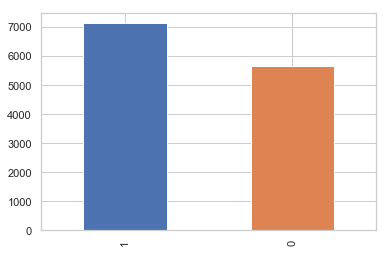

In [304]:
df['Label'].value_counts().plot(kind='bar')


In [305]:

df.columns[df.isnull().any()]


Index(['sub', 'speaker', 'job', 'state', 'party', 'bare', 'false', 'half_true',
       'mostly', 'pantson', 'location'],
      dtype='object')

In [306]:
miss = df.isnull().sum()/len(df)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

sub          0.000156
speaker      0.000156
party        0.000156
bare         0.000156
false        0.000156
half_true    0.000156
mostly       0.000156
pantson      0.000156
location     0.010242
state        0.214917
job          0.278868
dtype: float64

AttributeError: module 'seaborn' has no attribute 'plt'

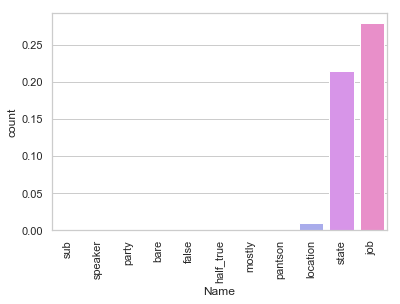

In [307]:
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
sns.plt.show()

In [308]:
df=df.drop('state',axis=1)
df=df.drop('job',axis=1)

In [309]:
df.isnull().sum()

ID             0
Label          0
Statement      0
sub            2
speaker        2
party          2
bare           2
false          2
half_true      2
mostly         2
pantson        2
location     131
dtype: int64

In [310]:
df['sub'].fillna(method='ffill',inplace=True)
df['speaker'].fillna(method='ffill',inplace=True)
df['party'].fillna(method='ffill',inplace=True)
df['bare'].fillna(method='ffill',inplace=True)
df['false'].fillna(method='ffill',inplace=True)
df['half_true'].fillna(method='ffill',inplace=True)
df['mostly'].fillna(method='ffill',inplace=True)
df['pantson'].fillna(method='ffill',inplace=True)
df['location'].fillna(method='ffill',inplace=True)

In [311]:
df.isnull().sum()

ID           0
Label        0
Statement    0
sub          0
speaker      0
party        0
bare         0
false        0
half_true    0
mostly       0
pantson      0
location     0
dtype: int64

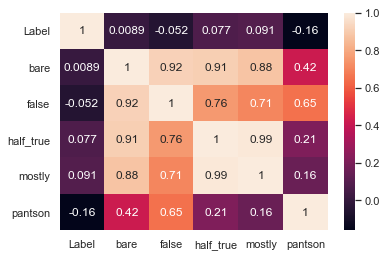

In [312]:
# Correlation between numerical Features
numerical=df.select_dtypes(include=[np.number])
sns.heatmap(numerical.corr(),annot=True)

C:\Users\Anirudha_Pratap\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Anirudha_Pratap\Anaconda3\lib\site-packages\scipy\stats\stats.py:2960: RuntimeWarning: divide by zero encountered in double_scalars
  msw = sswn / dfwn


<module 'matplotlib.pyplot' from 'C:\\Users\\Anirudha_Pratap\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

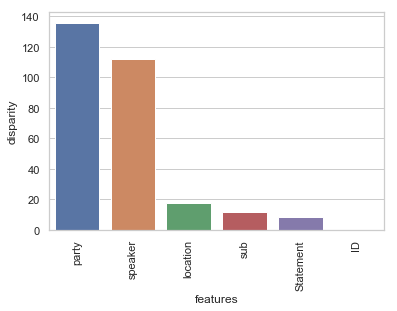

In [313]:
# categorical features Correlation using ANOVA
cat_data = df.select_dtypes(exclude=[np.number])
cat = [f for f in df.columns if df.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['Label'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['Label'] = df.Label.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

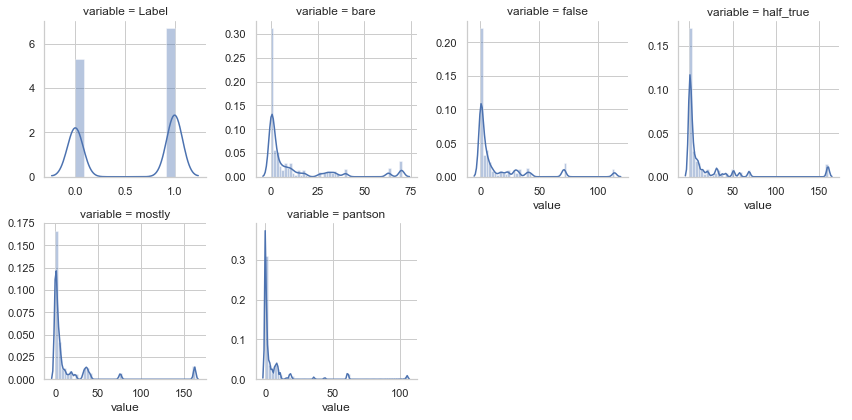

In [314]:
num = [f for f in df.columns if df.dtypes[f] != 'object']

nd = pd.melt(df, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [315]:
numeric_features = [f for f in df.columns if df[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = df[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
df[skewed] = np.log1p(df[skewed])
del df['ID']

In [316]:
df

,Label,Statement,sub,speaker,party,bare,false,half_true,mostly,pantson,location
0,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0.000000,0.693147,0.000000,0.000000,0.000000,a mailer
1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0.000000,0.000000,0.693147,0.693147,0.000000,a floor speech.
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,4.262680,4.276666,5.081404,5.099866,2.302585,Denver
3,0,Health care reform legislation is likely to ma...,health-care,blog-posting,none,2.079442,2.995732,1.386294,1.791759,3.806662,a news release
4,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,2.772589,2.302585,3.044522,2.995732,1.098612,an interview on CNN
5,1,The Chicago Bears have had more starting quart...,education,robin-vos,republican,0.000000,1.386294,1.098612,1.791759,0.693147,a an online opinion-piece
6,0,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,republican,1.386294,0.693147,0.693147,1.386294,0.693147,a press release.
7,1,I'm the only person on this stage who has work...,ethics,barack-obama,democrat,4.262680,4.276666,5.081404,5.099866,2.302585,"a Democratic debate in Philadelphia, Pa."
8,1,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,organization,0.000000,0.000000,0.693147,0.000000,0.693147,a website
9,1,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,republican,0.000000,0.000000,0.000000,0.693147,0.000000,an online video


In [317]:
numeric_features = [f for f in df.columns if df[f].dtype != object]
numeric_features.remove('Label')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[numeric_features])
scaled = scaler.transform(df[numeric_features])

for i, col in enumerate(numeric_features):
       df[col] = scaled[:,i]


scaled = scaler.fit_transform(df[numeric_features])

In [318]:
df

,Label,Statement,sub,speaker,party,bare,false,half_true,mostly,pantson,location
0,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,-1.091729,-0.616947,-1.108319,-1.084559,-0.825771,a mailer
1,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,-1.091729,-1.099403,-0.645056,-0.616044,-0.825771,a floor speech.
2,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,1.947115,1.877315,2.287823,2.362569,1.093035,Denver
3,0,Health care reform legislation is likely to ma...,health-care,blog-posting,none,0.390695,0.985738,-0.181793,0.126536,2.346424,a news release
4,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,0.884836,0.503282,0.926479,0.940332,0.089732,an interview on CNN
5,1,The Chicago Bears have had more starting quart...,education,robin-vos,republican,-1.091729,-0.134490,-0.374065,0.126536,-0.248153,a an online opinion-piece
6,0,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,republican,-0.103446,-0.616947,-0.645056,-0.147528,-0.248153,a press release.
7,1,I'm the only person on this stage who has work...,ethics,barack-obama,democrat,1.947115,1.877315,2.287823,2.362569,1.093035,"a Democratic debate in Philadelphia, Pa."
8,1,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,organization,-1.091729,-1.099403,-0.645056,-1.084559,-0.248153,a website
9,1,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,republican,-1.091729,-1.099403,-1.108319,-0.616044,-0.825771,an online video


In [319]:
df.party.unique()

array(['republican', 'democrat', 'none', 'organization', 'independent',
       'columnist', 'activist', 'talk-show-host', 'libertarian',
       'newsmaker', 'journalist', 'labor-leader', 'state-official',
       'business-leader', 'education-official', 'tea-party-member',
       'green', 'liberal-party-canada', 'government-body', 'Moderate',
       'democratic-farmer-labor', 'ocean-state-tea-party-action',
       'constitution-party', 'county-commissioner'], dtype=object)

In [320]:
df.speaker.values


array(['dwayne-bohac', 'scott-surovell', 'barack-obama', ...,
       'campaign-defend-america', 'americans-united-change',
       'rudy-giuliani'], dtype=object)

In [321]:
df.drop('location',axis=1,inplace =True)

In [322]:
df.speaker.unique

<bound method Series.unique of 0                                      dwayne-bohac
1                                    scott-surovell
2                                      barack-obama
3                                      blog-posting
4                                     charlie-crist
5                                         robin-vos
6                            republican-party-texas
7                                      barack-obama
8                                    oregon-lottery
9                                     duey-stroebel
10                                  robert-menendez
11                                         bernie-s
12                                      mitt-romney
13                                       doonesbury
14                                      george-will
15                                         bernie-s
16                                     barack-obama
17      national-republican-congressional-committee
18                               

In [323]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.data import load
from nltk.tokenize import regexp_tokenize
import re

In [324]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [325]:
df['Statement'] = np.vectorize(remove_pattern)(df['Statement'], "@[\w]*")

In [326]:
df['Statement'] = df['Statement'].str.replace("[^a-zA-Z#]", " ")

In [327]:
df['Statement'] = df['Statement'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [328]:
df.head()

,Label,Statement,sub,speaker,party,bare,false,half_true,mostly,pantson
0,0,Says Annies List political group supports thir...,abortion,dwayne-bohac,republican,-1.091729,-0.616947,-1.108319,-1.084559,-0.825771
1,1,When decline coal start started when natural t...,"energy,history,job-accomplishments",scott-surovell,democrat,-1.091729,-1.099403,-0.645056,-0.616044,-0.825771
2,1,Hillary Clinton agrees with John McCain voting...,foreign-policy,barack-obama,democrat,1.947115,1.877315,2.287823,2.362569,1.093035
3,0,Health care reform legislation likely mandate ...,health-care,blog-posting,none,0.390695,0.985738,-0.181793,0.126536,2.346424
4,1,economic turnaround started term,"economy,jobs",charlie-crist,democrat,0.884836,0.503282,0.926479,0.940332,0.089732


In [329]:
tokenized_tweet = df['Statement'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Says, Annies, List, political, group, support...
1    [When, decline, coal, start, started, when, na...
2    [Hillary, Clinton, agrees, with, John, McCain,...
3    [Health, care, reform, legislation, likely, ma...
4                [economic, turnaround, started, term]
Name: Statement, dtype: object

In [330]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [say, anni, list, polit, group, support, third...
1    [when, declin, coal, start, start, when, natur...
2    [hillari, clinton, agre, with, john, mccain, v...
3    [health, care, reform, legisl, like, mandat, f...
4                    [econom, turnaround, start, term]
Name: Statement, dtype: object

In [331]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['Statement'])
bow1= bow_vectorizer.fit_transform(df['speaker'])

In [332]:
print(bow.shape)

bow.shape

(12791, 1000)


(12791, 1000)

In [333]:
bow[:,:]

<12791x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 75378 stored elements in Compressed Sparse Row format>

In [334]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['Statement'])
#tfidf = tfidf_vectorizer.fit_transform(df['speaker'])

In [365]:
tfidf.shape

(12791, 1000)

In [371]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

trainx_bow = bow[:9000,:]
trainy_bow = df.loc[:9000-1,'Label']
testx_bow = bow[9000:,:]
testy_bow = df.loc[9000:,'Label']
# splitting data into training and validation set
# xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df['Label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(trainx_bow, trainy_bow) # training the model

prediction = lreg.predict_proba(testx_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.1 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(testy_bow, prediction_int) # calculating f1 score
lreg.score(testx_bow,testy_bow)

0.5900817726193617

In [372]:
trainx_bow = tfidf[:9000,:]+tfidf1[:9000,:]
trainy_bow = df.loc[:9000-1,'Label']
testx_bow = tfidf[9000:,:]+ tfidf1[9000:,:]
testy_bow = df.loc[9000:,'Label']
lreg.fit(trainx_bow, trainy_bow)

prediction = lreg.predict_proba(testx_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(testy_bow, prediction_int)
lreg.score(testx_bow,testy_bow)

0.6154049063571617

In [337]:
df

,Label,Statement,sub,speaker,party,bare,false,half_true,mostly,pantson
0,0,Says Annies List political group supports thir...,abortion,dwayne-bohac,republican,-1.091729,-0.616947,-1.108319,-1.084559,-0.825771
1,1,When decline coal start started when natural t...,"energy,history,job-accomplishments",scott-surovell,democrat,-1.091729,-1.099403,-0.645056,-0.616044,-0.825771
2,1,Hillary Clinton agrees with John McCain voting...,foreign-policy,barack-obama,democrat,1.947115,1.877315,2.287823,2.362569,1.093035
3,0,Health care reform legislation likely mandate ...,health-care,blog-posting,none,0.390695,0.985738,-0.181793,0.126536,2.346424
4,1,economic turnaround started term,"economy,jobs",charlie-crist,democrat,0.884836,0.503282,0.926479,0.940332,0.089732
5,1,Chicago Bears have more starting quarterbacks ...,education,robin-vos,republican,-1.091729,-0.134490,-0.374065,0.126536,-0.248153
6,0,Dunnam lived district represents years,candidates-biography,republican-party-texas,republican,-0.103446,-0.616947,-0.645056,-0.147528,-0.248153
7,1,only person this stage worked actively just la...,ethics,barack-obama,democrat,1.947115,1.877315,2.287823,2.362569,1.093035
8,1,However took million Oregon Lottery funds Port...,jobs,oregon-lottery,organization,-1.091729,-1.099403,-0.645056,-1.084559,-0.248153
9,1,Says primary opponents Glenn Grothman Leibham ...,"energy,message-machine-2014,voting-record",duey-stroebel,republican,-1.091729,-1.099403,-1.108319,-0.616044,-0.825771


In [363]:
#Feature Engineering

df['total']=np.sqrt(df.bare**2+df['false']**2+df['half_true']**2+df['mostly']**2+df['pantson']**2)

df['total']

0       2.158479
1       1.969280
2       4.396153
3       2.584393
4       1.669391
5       1.194770
6       0.943804
7       4.396153
8       2.013580
9       2.165719
10      1.222685
11      2.284882
12      3.309835
13      1.795102
14      0.572992
15      2.284882
16      4.396153
17      1.557012
18      0.309105
19      1.965267
20      1.551532
21      1.397613
22      3.357920
23      0.709174
24      2.156927
25      0.813936
26      3.357920
27      1.929975
28      1.961316
29      2.017429
          ...   
1254    2.158479
1255    3.309835
1256    1.667748
1257    1.941683
1258    1.420870
1259    0.895798
1260    0.673781
1261    1.551514
1262    4.407950
1263    0.696147
1264    1.397613
1265    1.781267
1266    1.005270
1267    1.288493
1268    2.158479
1269    4.396153
1270    1.254521
1271    1.941683
1272    4.396153
1273    1.558744
1274    1.464889
1275    2.900911
1276    1.538516
1277    1.676783
1278    0.796253
1279    4.396153
1280    3.357920
1281    1.8972

In [364]:

c=['bare','false','half_true','mostly','pantson','total']
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier


# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(df[c], df['Label'], random_state=42, test_size=0.3)

lreg = RandomForestClassifier(n_estimators=200,n_jobs=3)
lreg.fit(xtrain_bow, ytrain) # training the model

prediction1= lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int1 = prediction[:,1] >= 0.1 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int1 = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int1)

0.7300150829562594

In [344]:
Total_prediction=(f1_score(yvalid, prediction_int1)+
f1_score(yvalid, prediction_int))/2

In [345]:
Total_prediction

0.7300150829562594